In [ ]:
import ira
import seaborn as sns
from ira.analysis.dtw import k_means_clustering, knn, dtw_keogh_lower_bound, dtw_window_distance, dtw_distance
%run patterns.py

%alphalab dark

In [370]:
ohlc = pd.read_csv('../data/BTCUSDT_ohlcv_5Min.csv.gz', index_col='time', parse_dates=True)

# Splitting OHLC series into price movements

We are going to split price series into significant movements first using pivotal points. 
Example of pivot point in this case:
- price reaches high and then drop more than N percent down (local top / high)
- price reaches low and then rises more than N percent up (local bottom / low)

Question - what is correct procedure for defining N ? There are many ways how to choose it's value - just fixed percentage, fixed number of price points, percentage dependent on current volatility etc.

For first case we can use just fixed percentage as some first approximation just to see how it looks. Later we can test different approaches.

So for first tests wwe will use 5 min timeframe bars and 0.3% as some threshold for significance of price movement. 

Than smaller threshold we use than more detailed (noisy) movement series we get as result. So we can think about that as about some noise filter.

Minimal threshold can be estimated as minimal price change that can overcome trading costs.

In [371]:
lns = movements_tail_corrected(ohlc, 0.3)

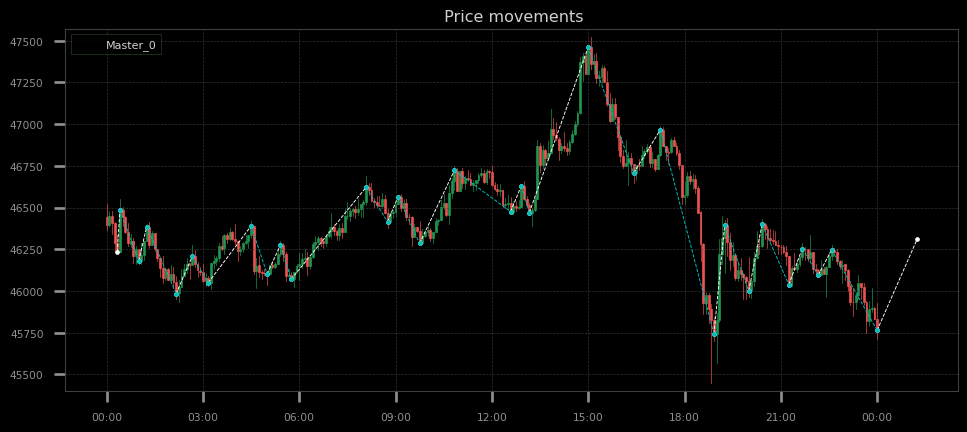

In [29]:
fig(12, 5)
lg = LookingGlass([ohlc, lns], backend='mpl')
lg.look('2022-01-04', '2022-01-05', title='Price movements')

# Distance metrics and normalization

- Split every day into trends
- Fill all points between reversal points by values derived from piecewise linear function
- Normilize

Following is proof of concept. First we define piecewise linearization function:

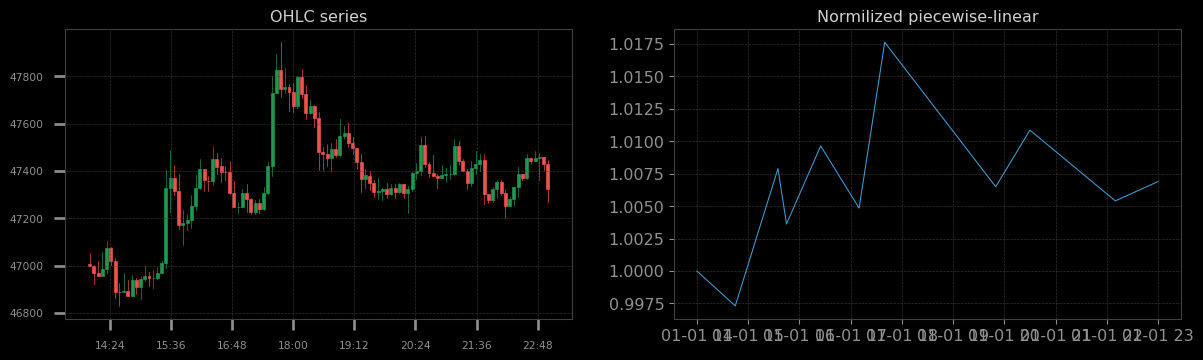

In [240]:
tX = ['2022-01-01 14:00', '2022-01-01 23:00']
fig(15, 4)
subplot(12,1); ohlc_plot(ohlc[tX[0]:tX[1]]); plt.title('OHLC series');
subplot(12,2); 
plt.plot(piecewise_linear(tX, ohlc, 0.3)); plt.title('Normilized piecewise-linear');

In [241]:
p1 = piecewise_linear('2022-01-04', ohlc, 0.3)
p2 = piecewise_linear('2022-01-07', ohlc, 0.3)

Now we can compare them visually 

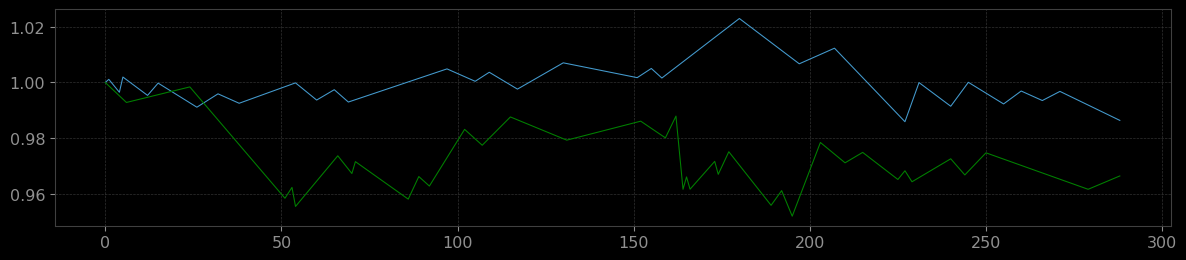

In [242]:
fig(15, 3)
plt.plot(p1.values); plt.plot(p2.values);

There is problem: how to introduce metric for measuring distance between two series.
There are many approaches, simplest one is equclidean distance measure in N-dimension.

## Euclidean metric 


$$ D(X,Y) = \sqrt{\sum{(X_i-Y_y)^2}}$$

There are two sufficient flaws for this approach:
- for big N in some cases we can't strictly identify differences based on just euclidian distance between two really different vectors.
- we can compare only equal vectors (so patterns must have same number of points - that is not the case in real world).

In [30]:
def euclidean_dist(x, y):
    return np.sqrt(np.square(x - y).sum() / (np.sum(x) * np.sum(y)))

### Issue1 - distances between different samples
There is example: we select 3 samples that look different enough.

In [ ]:
p1 = piecewise_linear('2022-01-04', ohlc, 0.3)
p2 = piecewise_linear('2022-01-10', ohlc, 0.3)
p3 = piecewise_linear('2022-01-31', ohlc, 0.3)

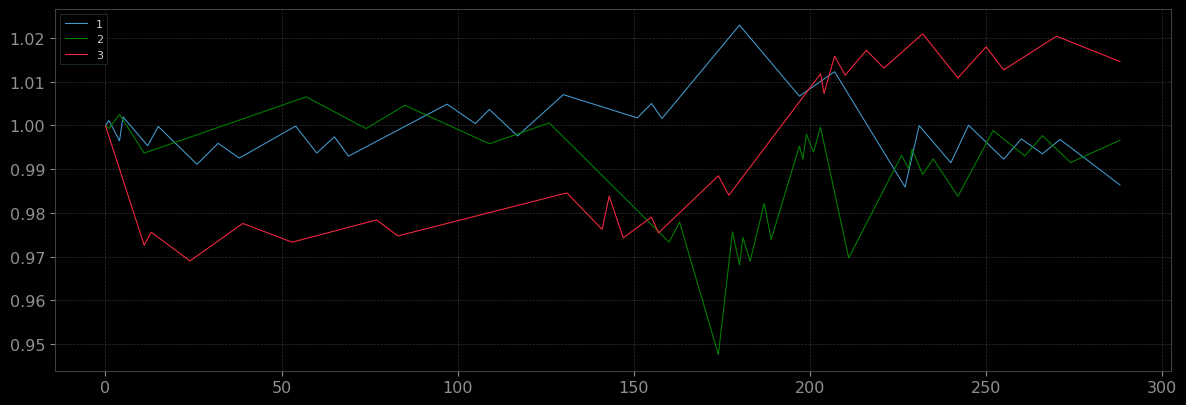

In [36]:
fig(15, 5)
plt.plot(p1.values); plt.plot(p2.values); plt.plot(p3.values);
plt.legend(['1', '2', '3']);

If now we find pairwise euclidian distances between samples (1-2, 1-3, 2-3) we can see that 2 and 3 are should be closer to each other (according numbers) but we see that it's not so from chart above.

In [334]:
print(f"\tEQ dist 1 ~ 2 : {euclidean_dist(p1.values, p2.values):.5f}\n" + 
      f"\tEQ dist 1 ~ 3 : {euclidean_dist(p1.values, p3.values):.5f}\n" + 
      f"\tEQ dist 2 ~ 3 : {euclidean_dist(p2.values, p3.values):.5f}")

EQ dist 1 ~ 2 : 0.00111
        EQ dist 1 ~ 3 : 0.00130
        EQ dist 2 ~ 3 : 0.00135

One of the ways to resolve this is using DTW (dynamic time warping method).

## Dynamic Time Warping [details](https://en.wikipedia.org/wiki/Dynamic_time_warping)

Now if we use DTW metric to get distances we see that all 3 samples are not similar based on DTW's metrics numbers !

In [339]:
print(f"\tDTW dist 1 ~ 2 : {dtw_distance(p1.values, p2.values):.5f}\n" + 
      f"\tDTW dist 1 ~ 3 : {dtw_distance(p1.values, p3.values):.5f}\n" + 
      f"\tDTW dist 2 ~ 3 : {dtw_distance(p2.values, p3.values):.5f}")

DTW dist 1 ~ 2 : 0.13815
        DTW dist 1 ~ 3 : 0.24472
        DTW dist 2 ~ 3 : 0.19139

### Issue2: for DTW we do not need to use vectors of same length to find the dictance

Let's take some samples from real data. One similar to HS (Head & Shoulders) and other that is not.

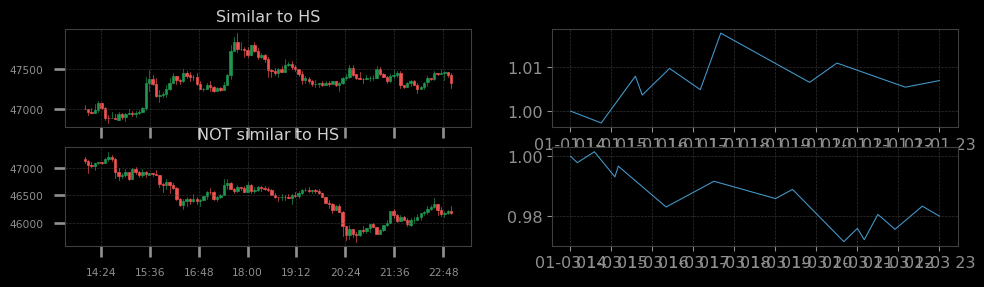

In [35]:
hsdata = piecewise_linear(['2022-01-01 14:00', '2022-01-01 23:00'], ohlc, 0.3)
no_hsdata = piecewise_linear(['2022-01-03 14:00', '2022-01-03 23:00'], ohlc, 0.3)
fig(12, 3)

sbp(22,1); 
ohlc_plot(ohlc['2022-01-01 14:00': '2022-01-01 23:00']); plt.title('Similar to HS');
sbp(22,2); plt.plot(hsdata)

sbp(22,3); 
ohlc_plot(ohlc['2022-01-03 14:00' : '2022-01-03 23:00']); plt.title('NOT similar to HS');
sbp(22,4);  plt.plot(no_hsdata)

Now we will define a pattern (actually something looks like H & S drawn by hand on chart):

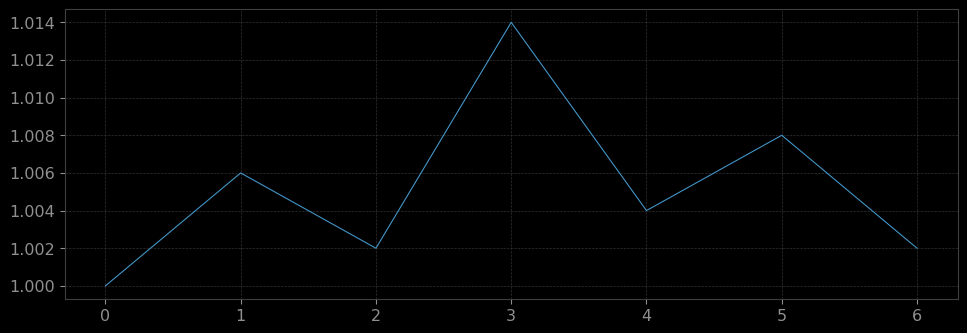

In [23]:
art_pattern = 1 + np.array([0, 0.3, 0.1, 0.7, 0.2, 0.4, 0.1 ]) / 50 
fig(12, 4)
plt.plot(art_pattern);

Our task now is to find how our pattern is close to samples taken from real data. 

So we will compare left charts against our right pattern and try to say if it looks like a HS from quantitative pount of view:

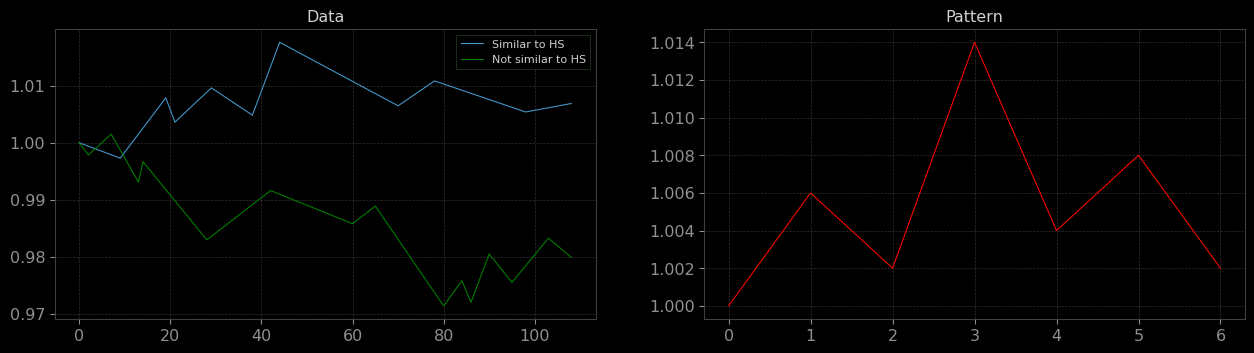

In [25]:
fig(16, 4)
sbp(12,1)
plt.plot(hsdata.values, label='Similar to HS')
plt.plot(no_hsdata.values, label='Not similar to HS'); plt.title('Data');
plt.legend()
sbp(12,2)
plt.plot(art_pattern, c='r'); plt.title('Pattern');

In [37]:
print(f">> Distance from PATTERN to sample similar to HS:  {dtw_distance(art_pattern, hsdata):.5f}" )
print(f">> Distance from PATTERN to sample NOT similar to HS:  {dtw_distance(art_pattern, no_hsdata):.5f}" )

>> Distance from PATTERN to sample similar to HS:  0.02058

>> Distance from PATTERN to sample NOT similar to HS:  0.17152

> So we can see that sample that we identified as 'something similar to HS' (blue line) is much closer (distance is less) to our desired pattern compared to sample that does't look like a HS.

<hr/>
Next steps:
<hr/>

 - run KNN using DTW distance metric to spot available clusters of patterns
 


 - try to define some pattern more accurately (any - like H&S etc) and find all closer samples on real data (5min, 15min, etc). Then check how price evolves after each of such spotted case.
